# Test Notebook

In [10]:
# import the usual suspects
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

In [7]:
# functions to compute Black-Scholes option prices
def bs_d_one(S, K, sigma, delta_T):
    
    return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (sigma**2)/2 * delta_T)

def compute_prices(pxs, K, sigma, T, call=True):
    
    # calculate d1 and d2
    d_one = bs_d_one(pxs, K, sigma, T)
    d_two = d_one - sigma * T**0.5
    # compute deltas and prices
    if call:
        deltas = stats.norm.cdf(d_one)
        prices = pxs * deltas - stats.norm.cdf(d_two) * K
    else:
        deltas = stats.norm.cdf(d_one) - 1
        prices = stats.norm.cdf(-d_two) * K + deltas * pxs
    
    return prices, deltas

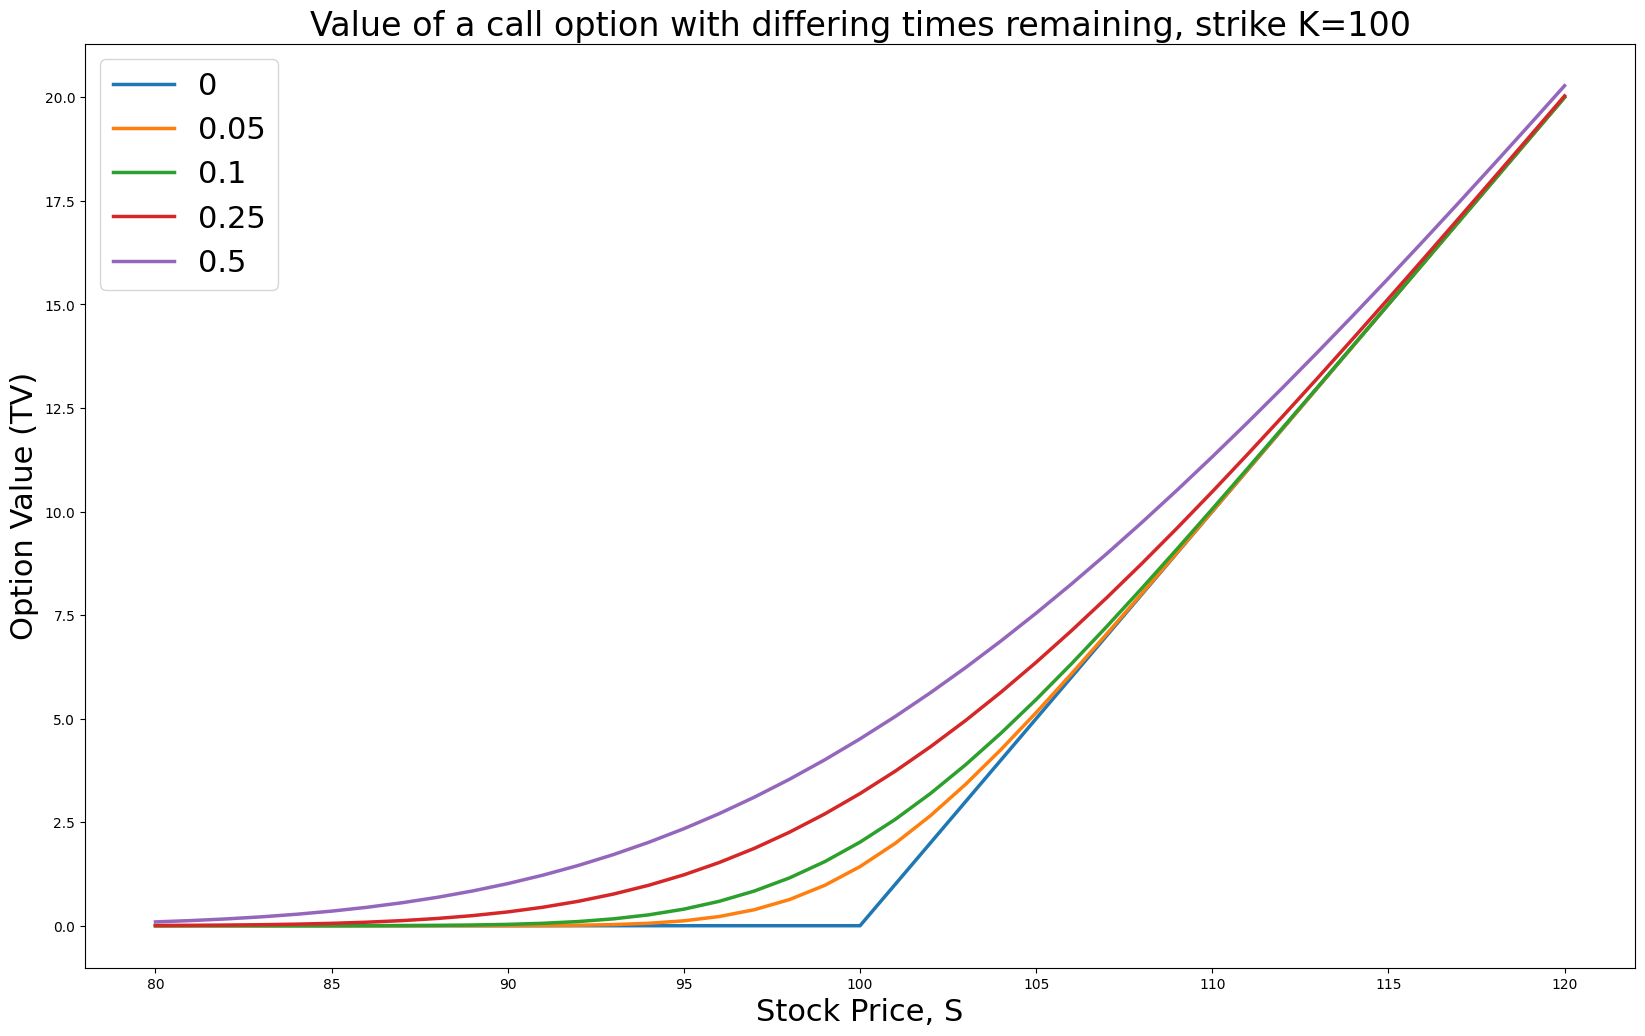

In [9]:
K = 100
sigma = 0.16
pxs = np.linspace(80, 120, 41)
times = [0.05, 0.1, 0.25, 0.5]
res = {}

for t in times:
    op_pxs = compute_prices(pxs, K, sigma, t, call=True)
    res[t] = op_pxs[0]

fig, ax = plt.subplots(figsize=(20,12))

call_pnls = [max(0, s - K) for s in pxs]
ax.plot(pxs, call_pnls, lw=2.5, label='0')

for l, ps in res.items():
    ax.plot(pxs, ps, lw=2.5, label=l)

ax.set_title('Value of a call option with differing times remaining, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)

ax.legend(fontsize=22);

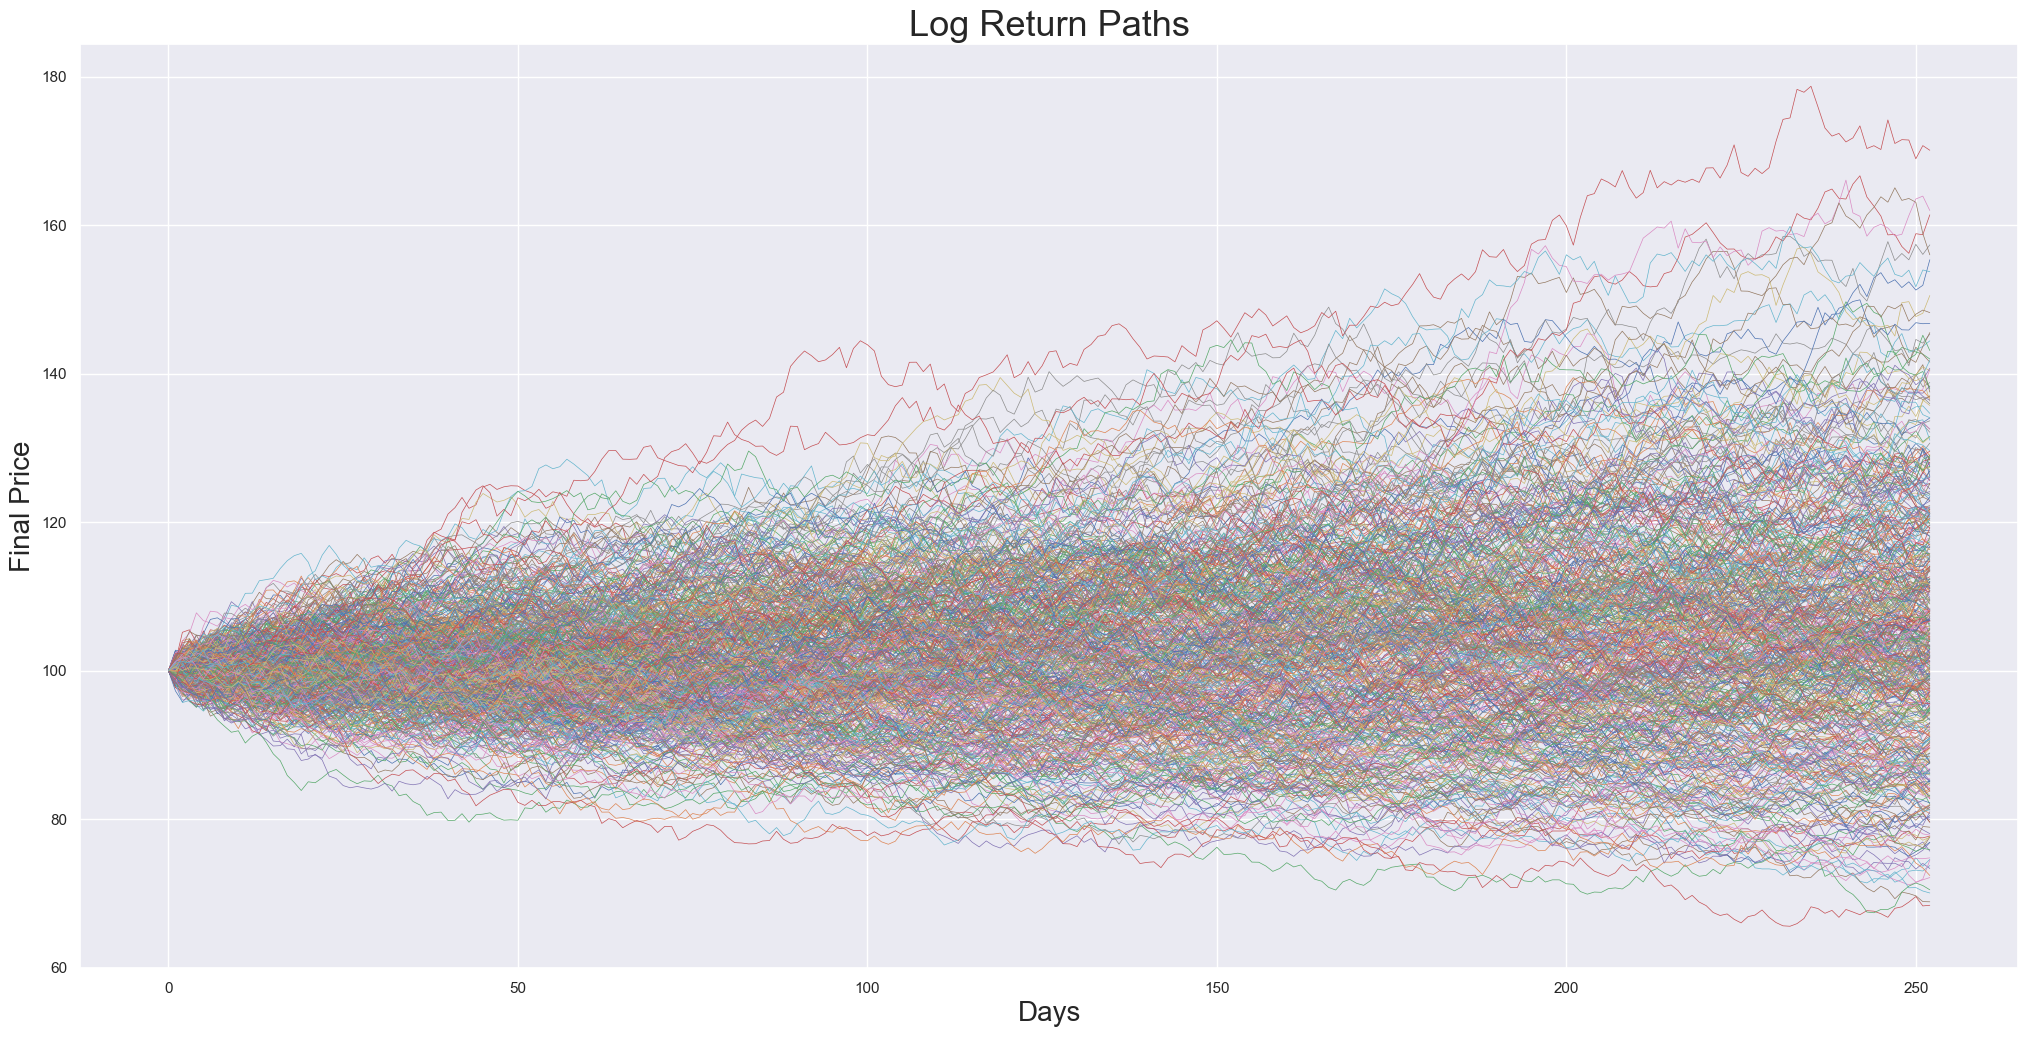

In [11]:
# function to generate the stock price series
def generate_paths(spot, drift, sigma, years, points, sims):
    
    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # create random numbers
    dW = rng.normal(size=(sims, points * years))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    
    return daily_devs, pxs


# determine our process parameters
px = 100
sigma = 0.16
risk_free = 0.05
divs = 0.00

# determine our sim settings
# i.e. we want 10,000 sets of 252 random numbers
sims = 10000
points = 252
years = 1

# churn out sims
rets, pxs = generate_paths(px, risk_free - divs, sigma, years, points, sims)

# plot them
fig, ax = plt.subplots(figsize=(25,12))

for p in pxs[:500]:
    ax.plot([z for z in range(0, points*years+1)], p, linewidth=0.5)
    
ax.set_title('Log Return Paths', fontsize=26)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);

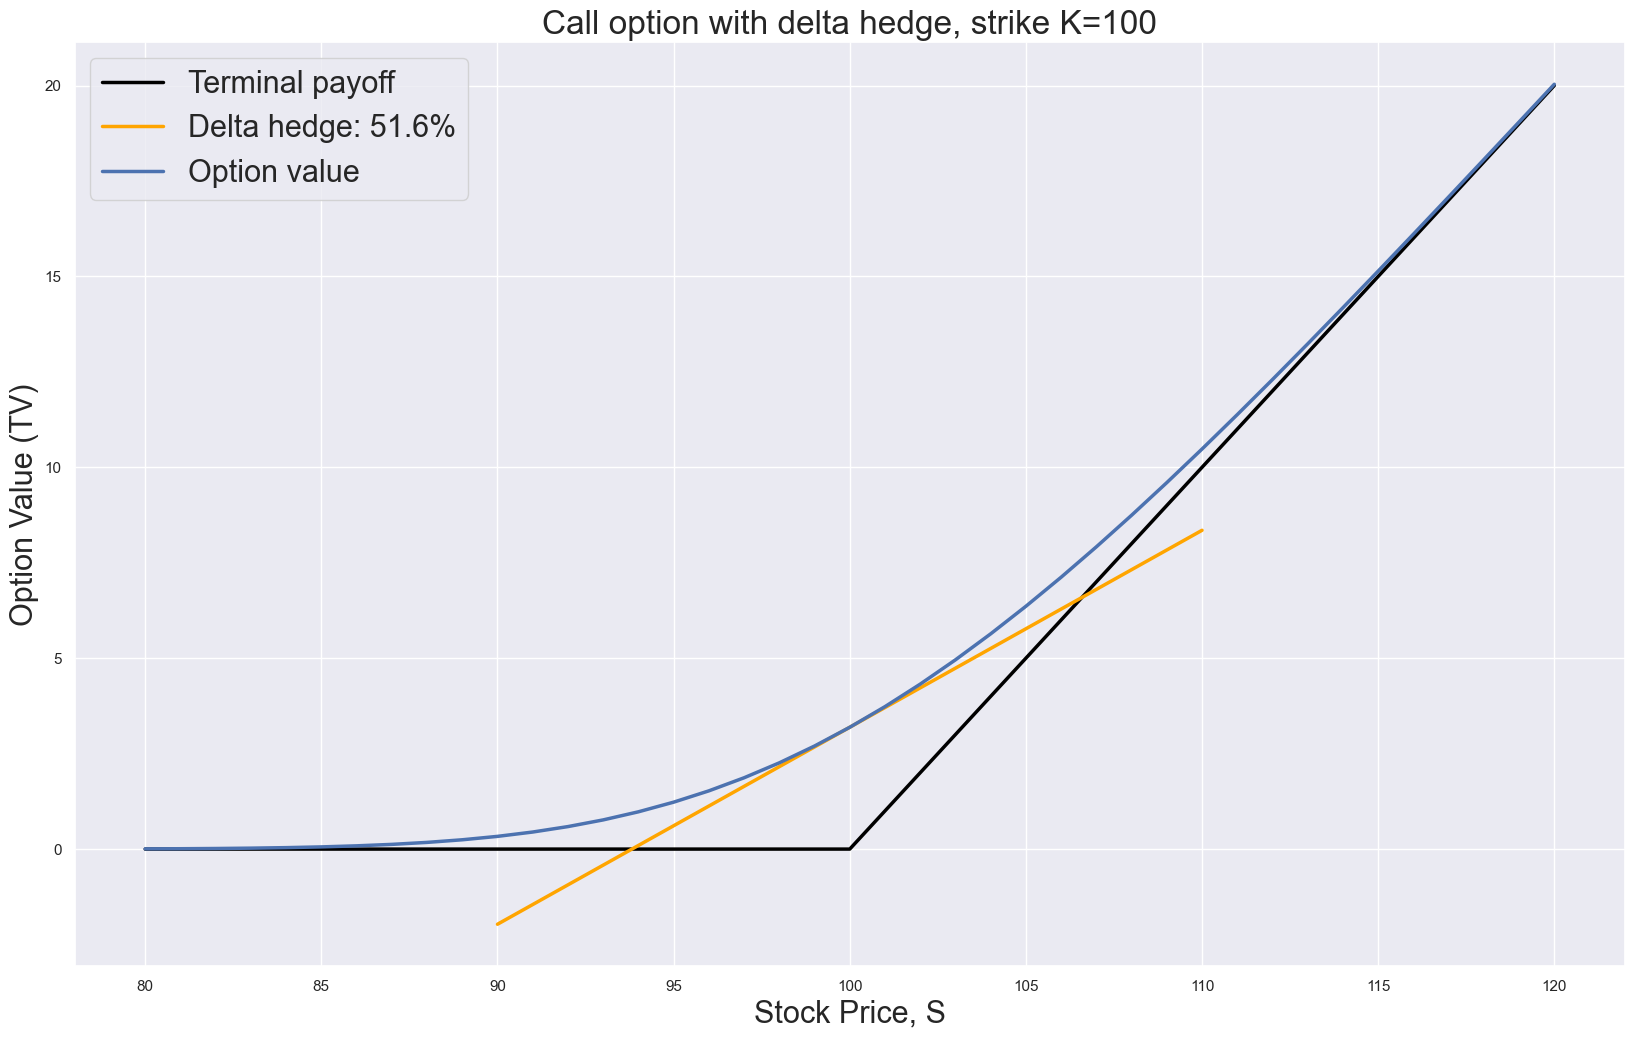

In [12]:
# functions to compute Black-Scholes option prices
def bs_d_one_simple(S, K, sigma, delta_T):
    
    return (1 / (sigma * delta_T**0.5)) * (np.log(S / K) + (sigma**2)/2 * delta_T)

def compute_prices_simple(pxs, K, sigma, T, call=True):
    
    # calculate d1 and d2
    d_one = bs_d_one_simple(pxs, K, sigma, T)
    d_two = d_one - sigma * T**0.5
    # compute deltas and prices
    if call:
        deltas = stats.norm.cdf(d_one)
        prices = pxs * deltas - stats.norm.cdf(d_two) * K
    else:
        deltas = stats.norm.cdf(d_one) - 1
        prices = stats.norm.cdf(-d_two) * K + deltas * pxs
    
    return prices, deltas

K = 100
sigma = 0.16
demo_pxs = np.linspace(80, 120, 41)

call_pnls = [max(0, s - K) for s in demo_pxs]
op_pxs = compute_prices_simple(demo_pxs, K, sigma, 0.25, call=True)
delta_hedge = [op_pxs[0][20] + op_pxs[1][20]* (p - 100) for p in np.linspace(90, 110, 21)]

fig, ax = plt.subplots(figsize=(20,12))

ax.plot(demo_pxs, call_pnls, lw=2.5, color='black', label='Terminal payoff')
ax.plot(np.linspace(90, 110, 21), delta_hedge, lw=2.5, color='orange', label='Delta hedge: {:.1%}'.format(op_pxs[1][20]))
ax.plot(demo_pxs, op_pxs[0], lw=2.5, label='Option value')

ax.set_title('Call option with delta hedge, strike K={}'.format(K), fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Option Value (TV)', fontsize=22)
ax.legend(fontsize=22);

In [14]:
from opcoes.black_scholes import compute_prices
from opcoes.simulation import generate_paths

In [17]:
risk_free = 0.05
divs = 0.00
sigma = 0.16
K = 100
call=True

# churn out sims
rets, pxs = generate_paths(px, risk_free - divs, sigma, years, points, sims)
# cvhurn out option tvs, deltas and gammas
call_pxs, deltas, gammas, vegas = compute_prices(pxs, K, risk_free, divs, sigma, points, years, call=call)

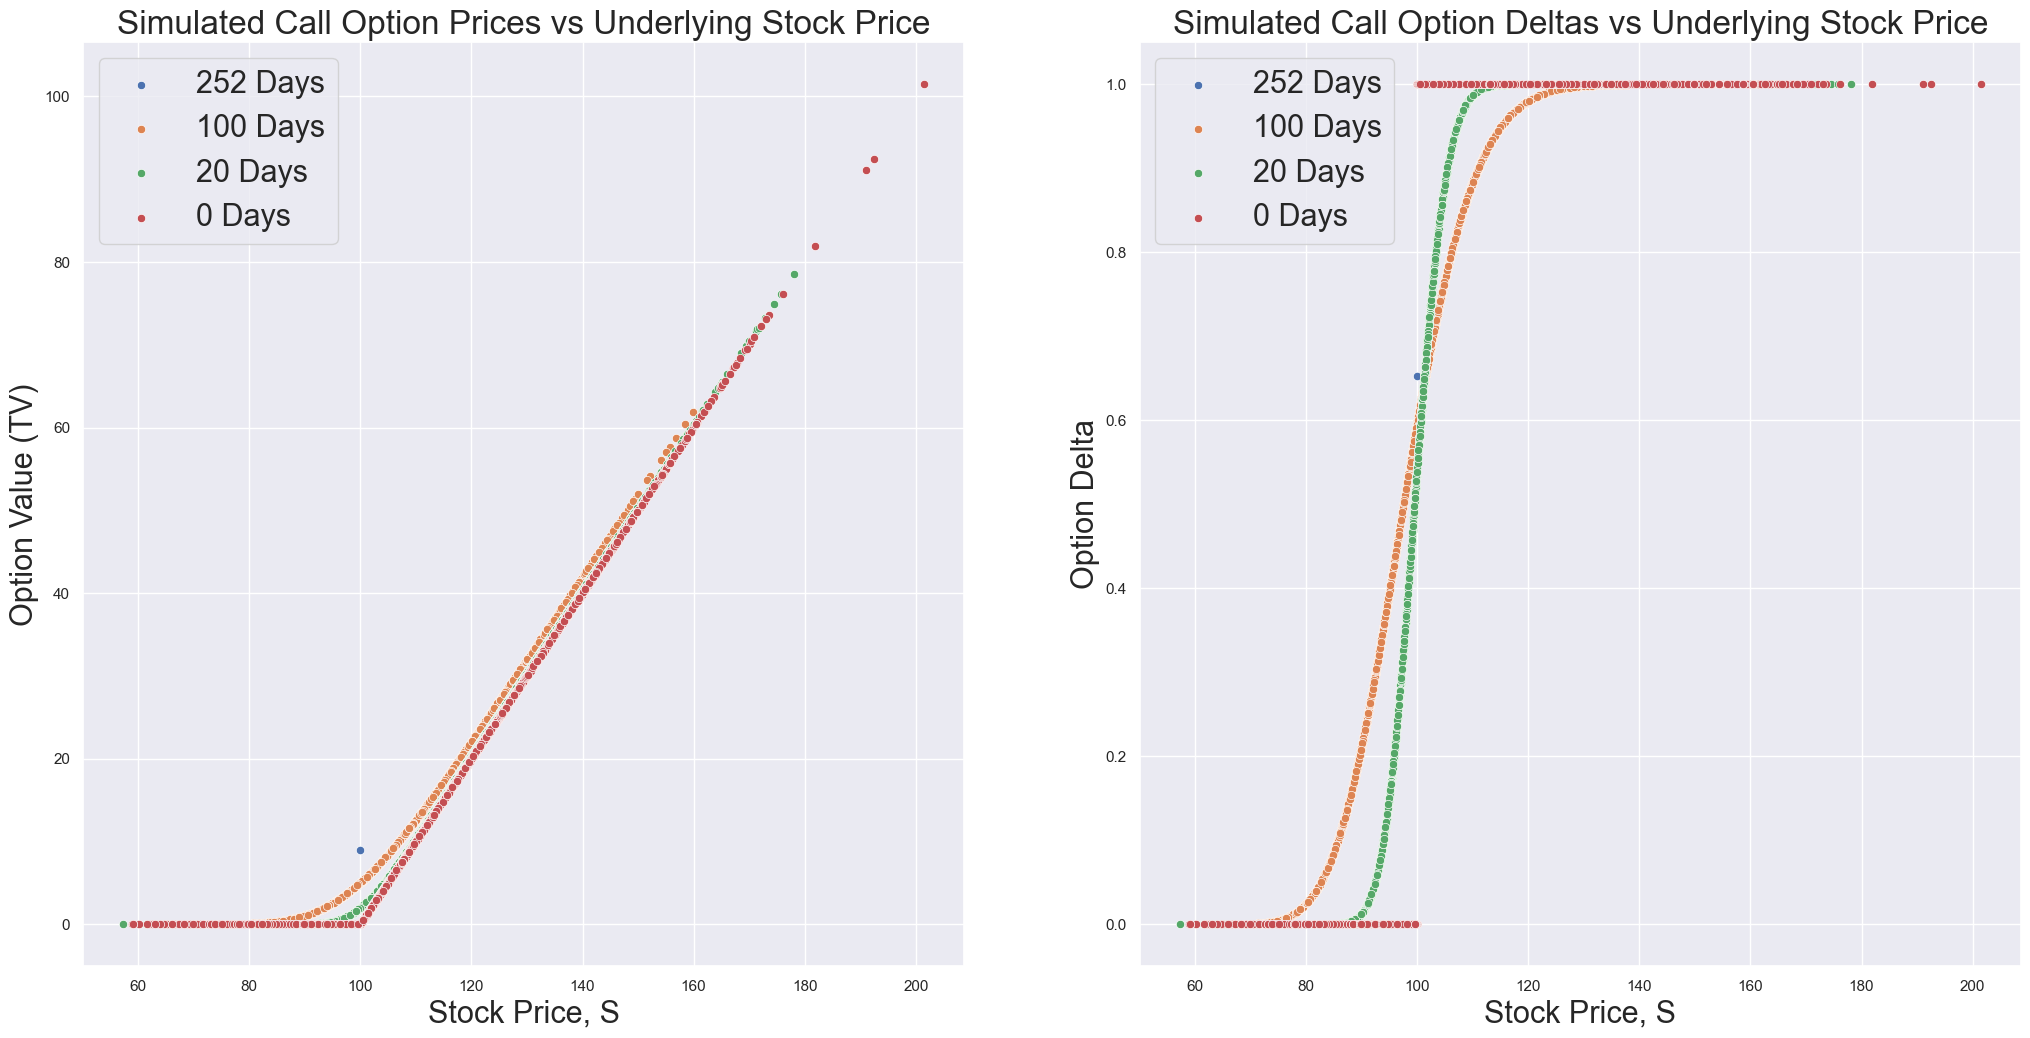

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(25, 12))
axes = axes.reshape(-1)

ts = [-253, -101, -21, -1]

for t in ts:
    
    prices = pxs[:,t]
    call_prices = call_pxs[:,t]
    call_deltas = deltas[:,t]
    
    sns.scatterplot(x=prices, y=call_prices, ax=axes[0], label=f"{-t-1} Days")
    sns.scatterplot(x=prices, y=call_deltas, ax=axes[1], label=f"{-t-1} Days")

axes[0].set_title('Simulated Call Option Prices vs Underlying Stock Price', fontsize=24)
axes[0].set_xlabel('Stock Price, S', fontsize=22)
axes[0].set_ylabel('Option Value (TV)', fontsize=22)
axes[0].legend(fontsize=22)

axes[1].set_title('Simulated Call Option Deltas vs Underlying Stock Price', fontsize=24)
axes[1].set_xlabel('Stock Price, S', fontsize=22)
axes[1].set_ylabel('Option Delta', fontsize=22)
axes[1].legend(fontsize=22);

In [24]:
# compute stock values at each point in time
stock_values = pxs * deltas

In [22]:
# compute cash flows from various activities
# at each point we will add on cash flows to the future valued version
# of last period's cash balance - this gives us our new cash balance

# cash flow from delta hedging
# compute cash generated from delta re-hedging
delta_chgs = np.diff(deltas, axis=1)
delta_rehedge_cfs = -delta_chgs * pxs[:,1:]

# compute dividend income
div_cfs = deltas[:,:-1] * pxs[:,:-1] * divs / points

# compute starting premium and delta cfs
start_cbs = call_pxs[:,0] - deltas[:,0] * pxs[:,0]

# init our cash balance and cashflow arrays
cbs = [start_cbs]
cfs = [np.zeros(sims)]

for drh, dcf in zip(delta_rehedge_cfs.T, div_cfs.T):
    
    # get previous cash balance
    prev_cash = cbs[-1]
    # future value it
    new_cash = prev_cash * (1 + risk_free / points)
    # add on new cash flows
    cf = drh + dcf
    cb = new_cash + cf
    cfs.append(cf)
    cbs.append(cb)

cfs = np.array(cfs).T
cbs = np.array(cbs).T

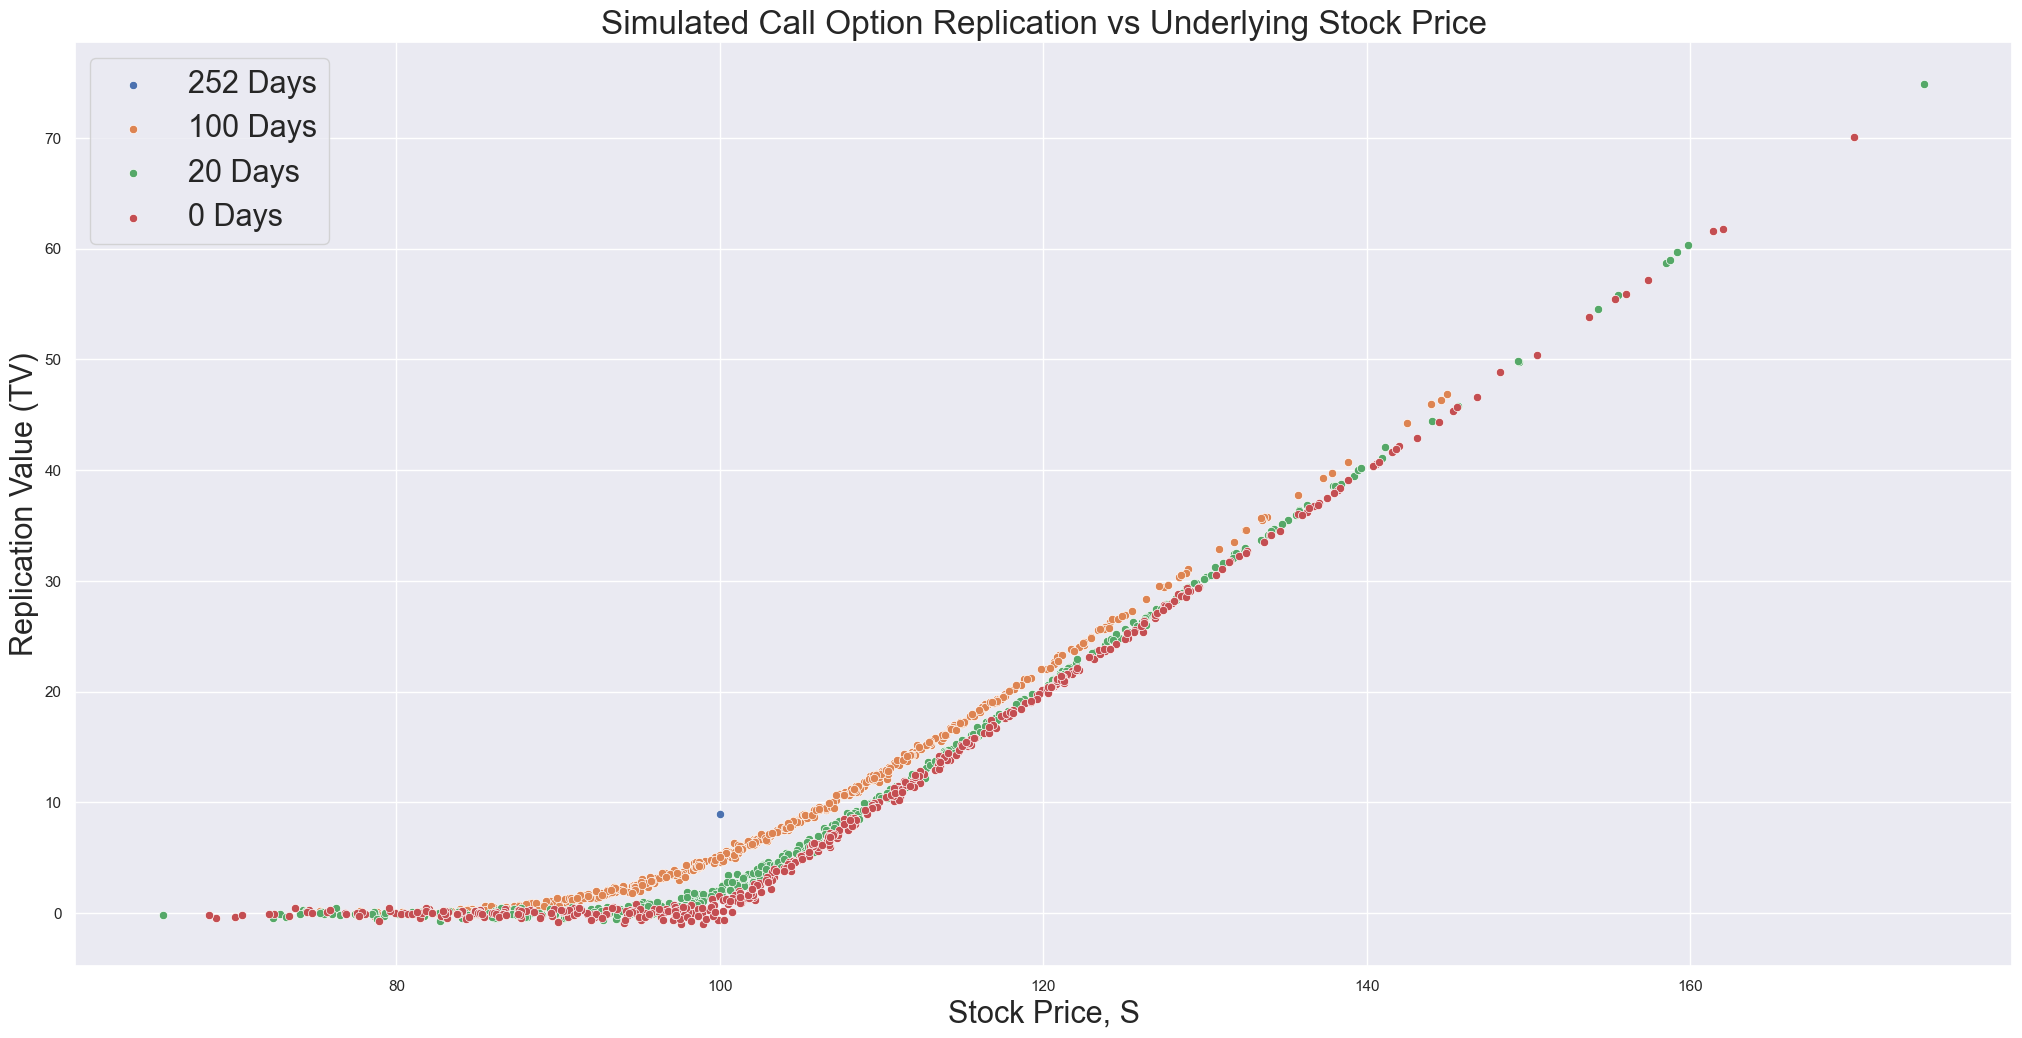

In [25]:
fig, ax = plt.subplots(figsize=(25, 12))

ts = [-253, -101, -21, -1]

for t in ts:
    
    prices = pxs[:500, t]
    repl_pxs = cbs[:500, t] + stock_values[:500, t]
    
    sns.scatterplot(x=prices, y=repl_pxs, ax=ax, label="{} Days".format(-t-1))

ax.set_title('Simulated Call Option Replication vs Underlying Stock Price', fontsize=24)
ax.set_xlabel('Stock Price, S', fontsize=22)
ax.set_ylabel('Replication Value (TV)', fontsize=22)
ax.legend(fontsize=22);